# Year Season Time Series 

| Northern hemisphere | Southern hemisphere | Start date |	End date|  
|---------------------|---------------------|------------|----------|
| Winter | 	Summer 	  | 1 December |	28 February |
| Spring | 	Autumn 	  | 1 March    |    31 May  |
| Summer |	Winter 	  | 1 June 	   | 31 August  |
| Autumn 	| Spring 	| 1 September 	|30 November   |

https://en.wikipedia.org/wiki/Season

**Steps**

1. Detectar si hubo o no WE por semana
2. Contar NMAX de valores posibles por mes
3. contar NVAL num de valores validos por mes
4. Contar NWE num de we por mes
5. (NWE/NVAL)*NMAX nos da una aproximacion de weekend effect por mes
6. Hacer esto mismo pero por estaciones meteorologicas del ano

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
import statsmodels.graphics.tsaplots as tsa
plt.rcParams["figure.figsize"] = [16.4, 6.8] 

In [94]:
df = pd.read_csv("sample/sample.csv")
sites = list(df.columns[1:])
l = len(df[sites])

dates = pd.to_datetime(df["date"],format = '%Y-%m-%d')
#df.set_index("date")

In [99]:
df["date"]= dates

df = df.set_index("date")


In [110]:
((df[sites]>0)*1).resample("M")

,CUA,FAC,MER,MON,PED,SAG,TAH,TLA,UIZ,XAL
date,,,,,,,,,,
1994-01-31,0,0,0,0,0,0,0,0,0,0
1994-02-28,1,0,1,1,0,0,1,0,1,0
1994-03-31,0,0,0,0,0,0,0,0,0,0
1994-04-30,0,0,0,0,0,1,1,0,0,0
1994-05-31,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1999-07-31,0,0,0,0,0,0,0,0,0,0
1999-08-31,0,0,1,0,0,0,0,1,1,0
1999-09-30,1,1,1,0,1,1,1,1,1,1


In [73]:

bin_df = df[sites]>0
bin_df["date"] = pd.to_datetime(df["date"])
bin_df.set_index("date")

#bin_df

#bin_df
bin_df.index

RangeIndex(start=0, stop=71, step=1)

In [60]:
bin_df.resample("M")

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

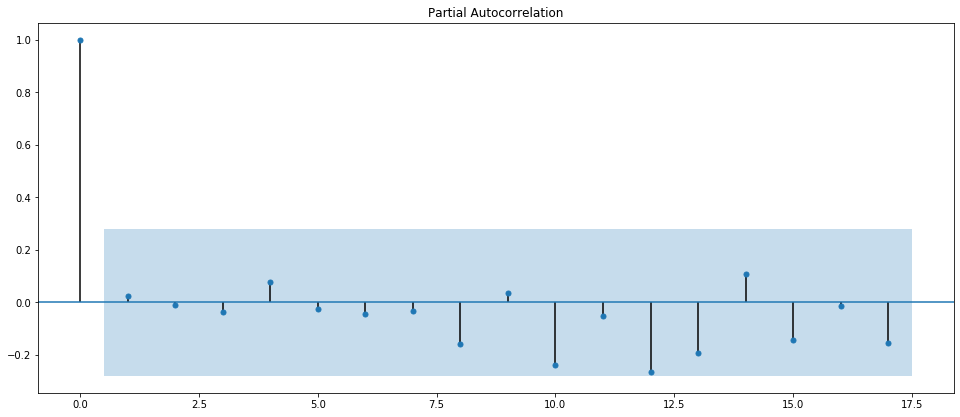

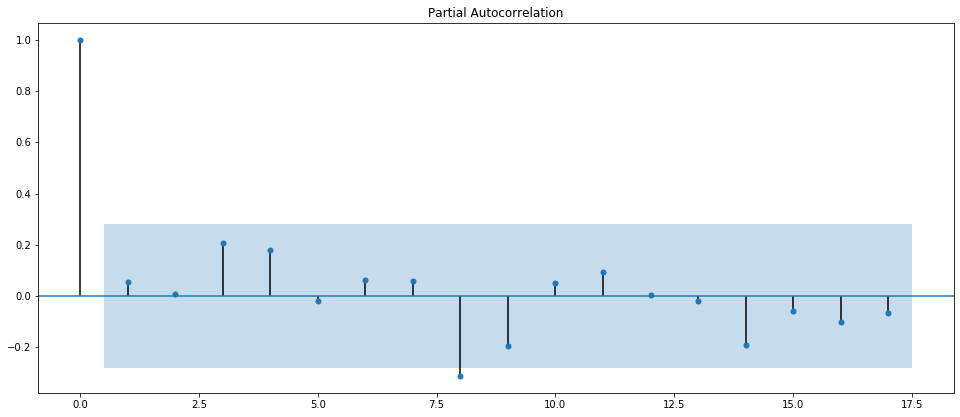

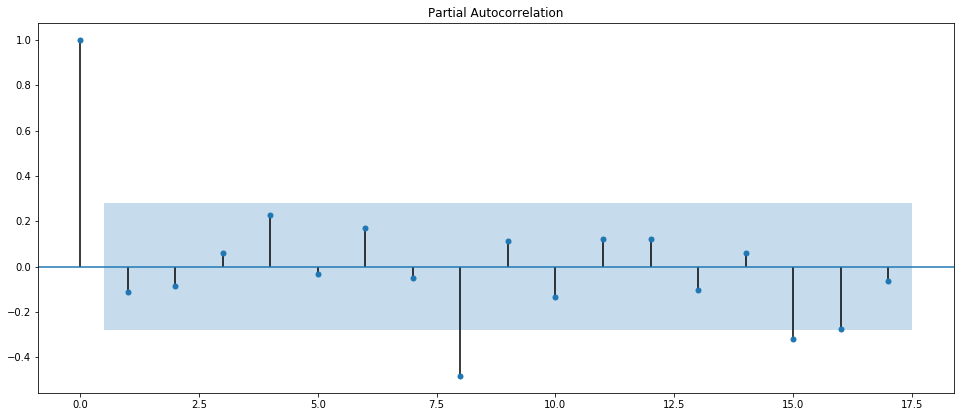

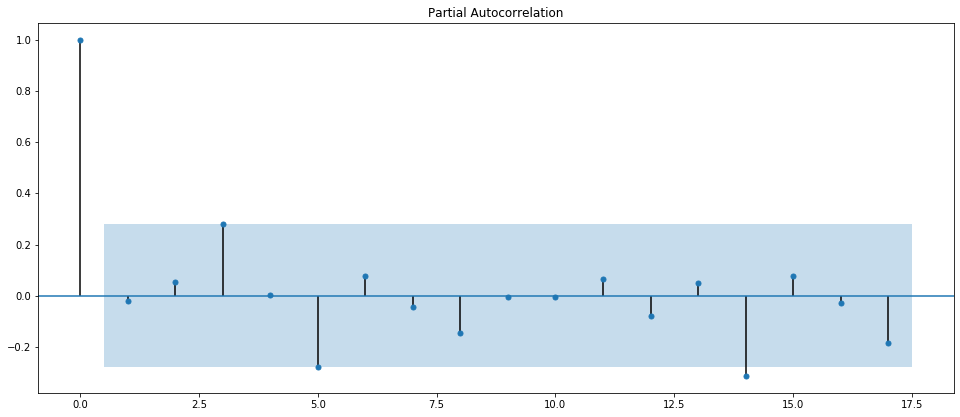

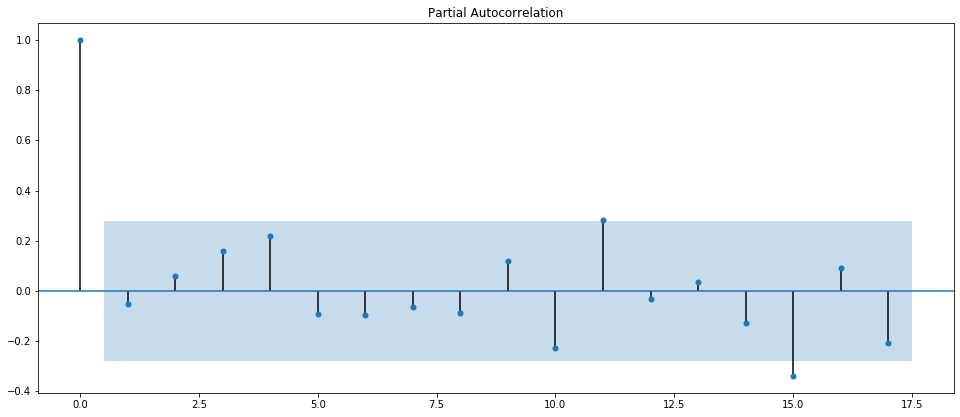

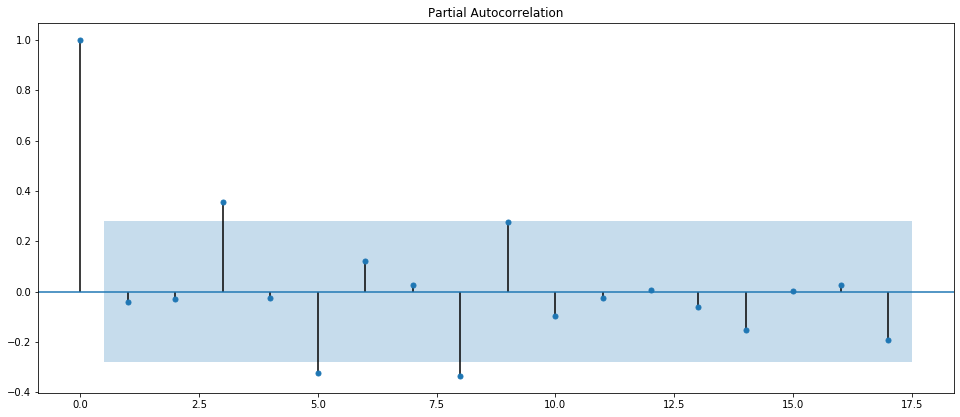

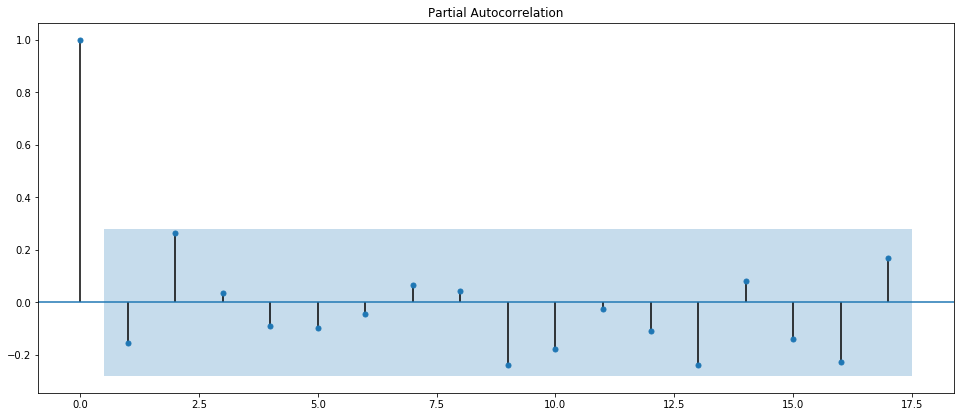

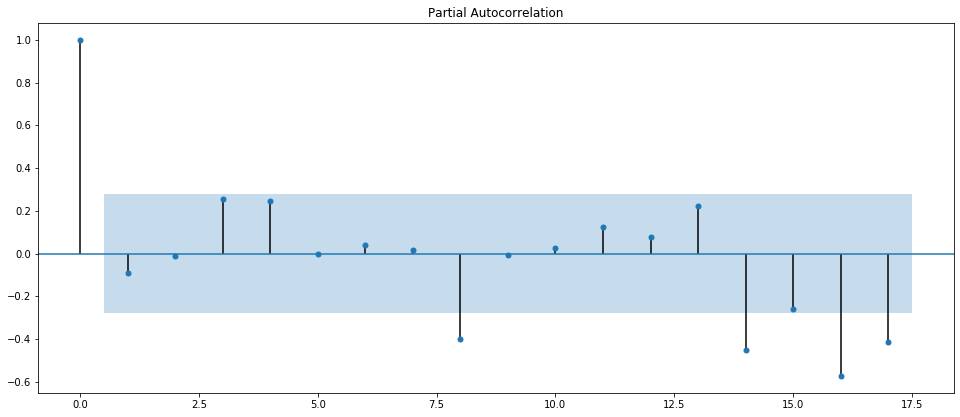

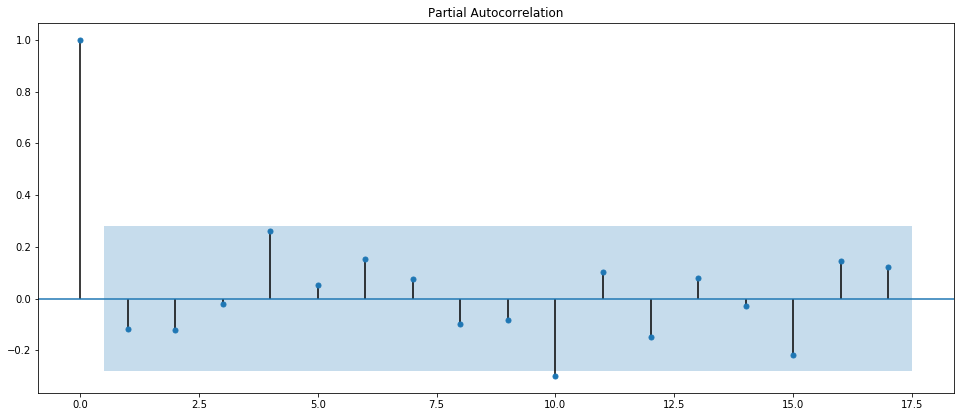

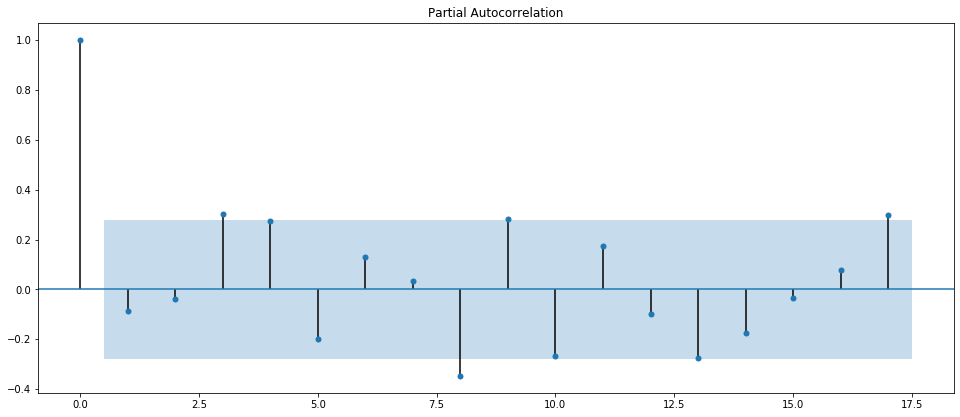

In [126]:
for s in sites:
    y = df[s][:int(0.7*l)]
    #df["group"]=np.arange(len(df))//6
    #y = df.groupby("group").sum()[s]
   
    
    
 #   autocorrelation_plot(y)
    tsa.plot_pacf(y)
 #   plt.hist(y)
    plt.show()

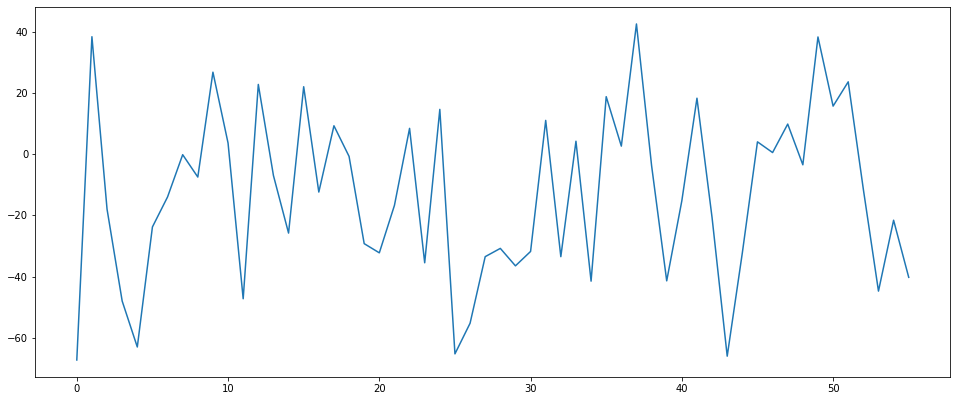

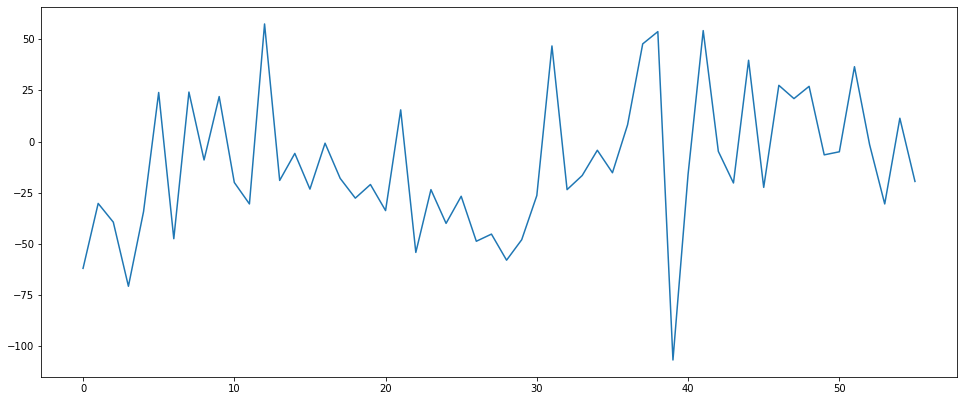

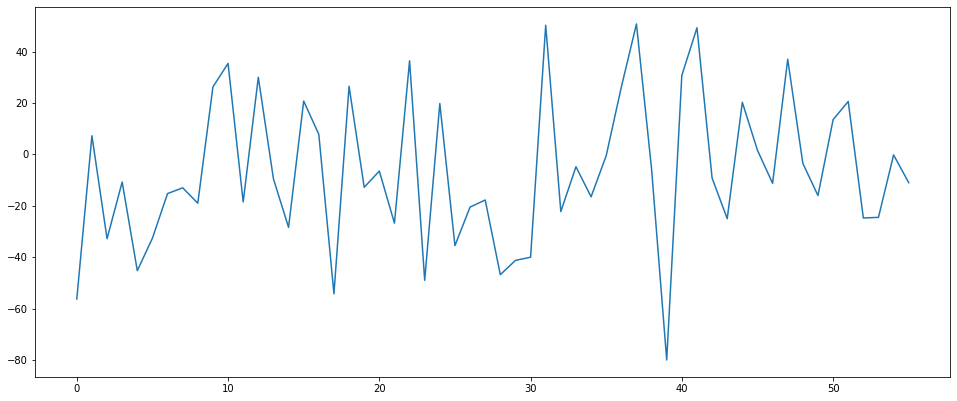

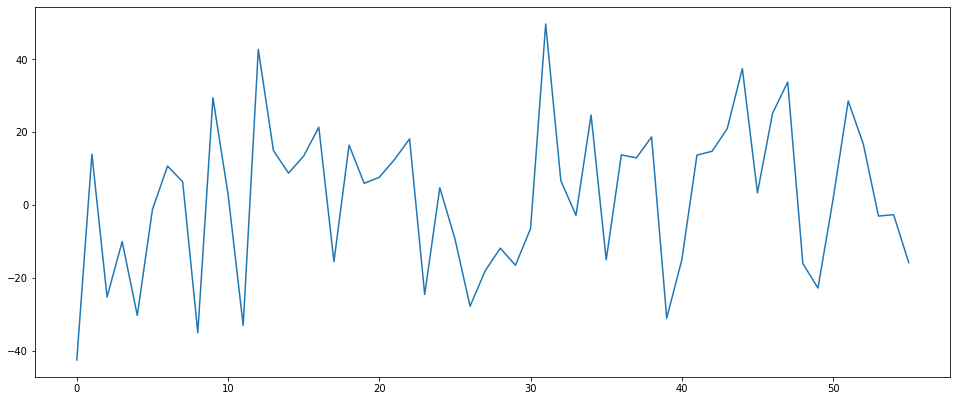

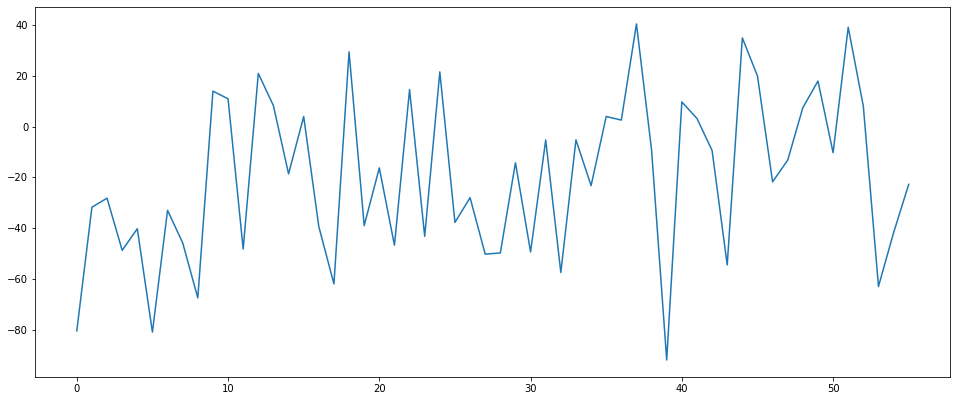

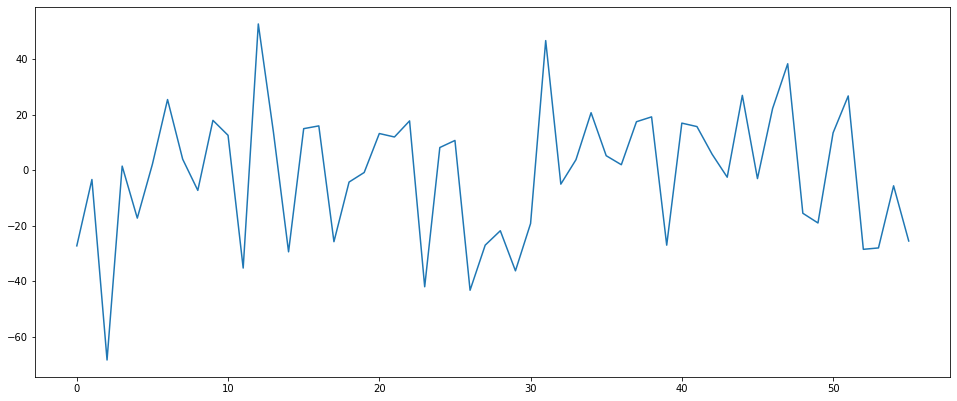

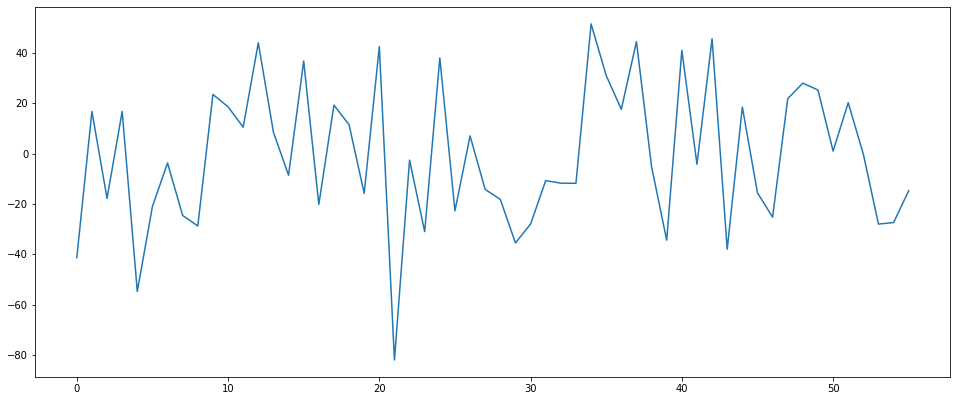

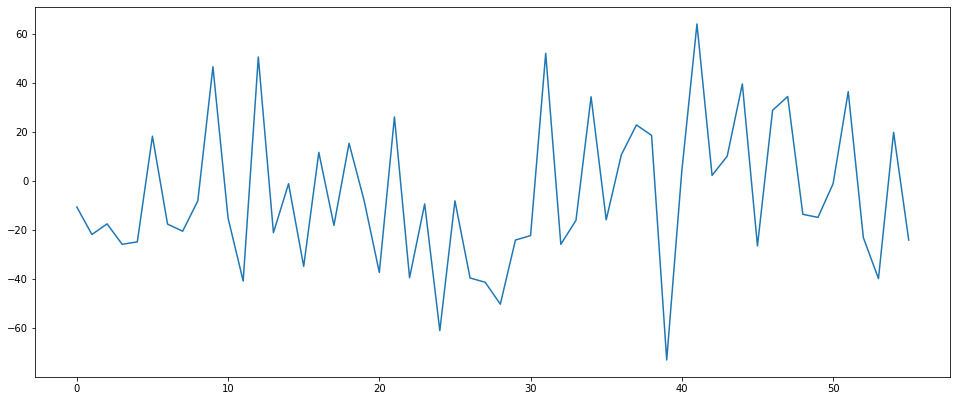

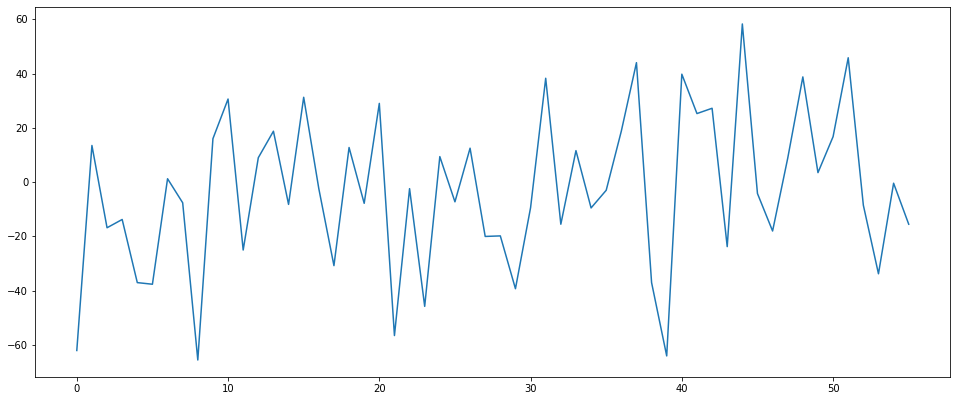

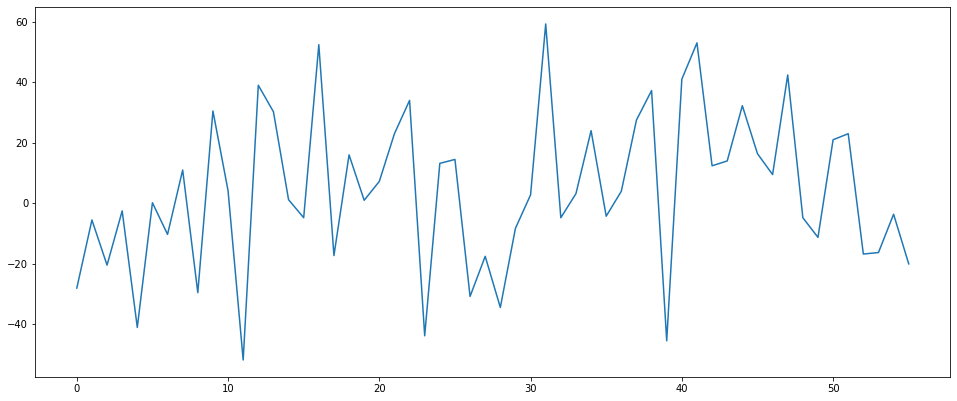

In [8]:

l = len(df[sites])

for s in sites:
    y = df[s][:int(0.8*l)]
    plt.plot(y)
    plt.show()

,CUA,FAC,MER,MON,PED,SAG,TAH,TLA,UIZ,XAL
group,,,,,,,,,,
0,-46.916667,-131.650000,-81.800000,-53.700000,-140.45,-98.983333,-42.383333,-49.65,-65.30,-53.90
1,-134.800000,-81.000000,-88.600000,-41.450000,-170.00,-13.550000,-59.000000,-32.10,-88.35,-43.30
2,-21.700000,-32.300000,-47.250000,-17.850000,-146.30,22.250000,-57.100000,-45.90,-71.85,-28.75
3,-16.900000,-28.500000,43.150000,-0.500000,-23.25,-4.650000,52.600000,-9.00,21.60,-17.05
4,-10.050000,32.700000,-7.900000,66.550000,10.65,37.100000,43.900000,28.75,19.55,70.45
5,18.850000,-42.050000,-25.700000,19.400000,-97.40,5.250000,35.800000,-40.95,-1.90,30.40
6,-62.250000,-82.416667,7.200000,30.166667,-25.75,8.200000,38.200000,-29.75,33.95,24.25
7,-43.850000,-62.200000,-39.350000,6.200000,-75.40,-12.200000,-115.600000,-22.40,-104.65,13.25
8,-105.900000,-115.500000,-36.200000,-32.200000,-44.15,-24.300000,22.250000,-108.50,14.65,-3.05


71

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


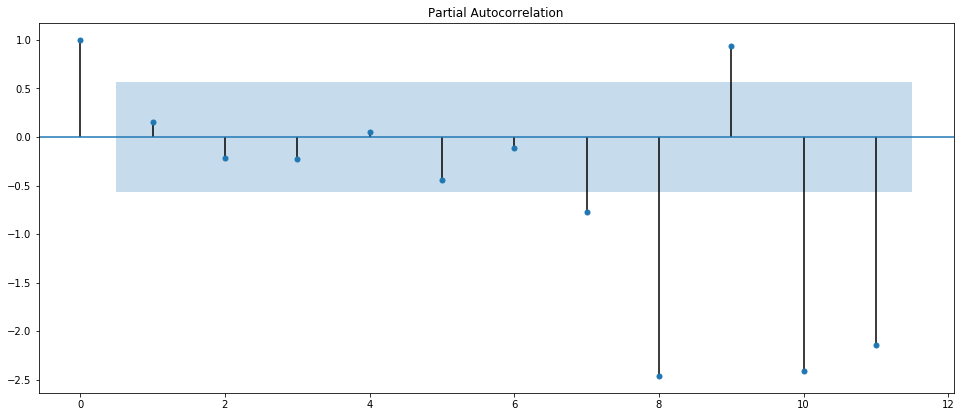

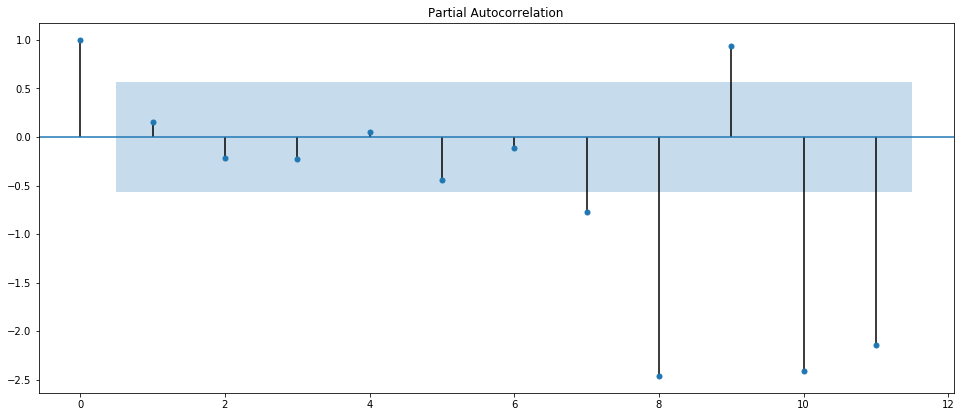

In [119]:
y

group
0     -97.20
1     -45.80
2     100.85
3      37.50
4     -63.20
5      80.25
6     117.35
7     126.95
8      -5.00
9      13.00
10   -163.70
11     16.50
Name: XAL, dtype: float64